In [ ]:
!nvidia-smi

Sun Aug  2 10:52:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

from google.colab import drive
drive.mount('/content/drive')

In [2]:
%cd "drive/My Drive/play_detora/notebook"

/content/drive/My Drive/play_detora/notebook


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.ops.boxes import box_area
from torchvision.ops.misc import FrozenBatchNorm2d
from torchvision.models._utils import IntermediateLayerGetter

import io
import re
import os
import sys
import cv2
import json
import glob
import copy
import tarfile
import collections
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from scipy.optimize import linear_sum_assignment
from sklearn.model_selection import train_test_split

In [4]:
root_dir = os.path.dirname(os.getcwd())
src_dir = os.path.join(root_dir, "src")
out_dir = os.path.join(root_dir, "result")
model_save_dir = os.path.join(out_dir, "20200718")
data_dir = os.path.join(root_dir, "dataset")
json_path = os.path.join(data_dir, "detection.json")
tar_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar")
img_dir = os.path.join(data_dir, "VOCdevkit", "VOC2012", "JPEGImages")
xml_paths = os.path.join(data_dir, "VOCdevkit", "VOC2012", "Annotations", "*.xml")

In [5]:
sys.path.append(os.path.join(src_dir))
from pytorch_trainer import Trainer, Reporter

In [6]:
with open(json_path) as fr:
    file2obj = json.load(fr)
len(file2obj)

17125

In [7]:
voc_trainval = [(k, v) for k, v in file2obj.items()]
len(voc_trainval)

17125

In [8]:
voc_train, voc_valid = train_test_split(voc_trainval, test_size=0.1, random_state=0)
len(voc_train), len(voc_valid)

(15412, 1713)

In [9]:
classes = [] 
for _, objects in voc_valid:
    classes += [o['name'] for o in objects]
print(len(classes), len(list(set(classes))))

3907 20


In [10]:
class2id = {c: i for i, c in enumerate(sorted(list(set(classes))))}
id2class = {v: k for k, v in class2id.items()}

def _get_coord_and_class(objects, get_difficult=False):
    for o in objects:
        if not(get_difficult) and (o['difficult'] == '1'):
            continue
        
        class_id = class2id[o['name']]
        bndbox = o['bndbox']
        coord = np.array([
            [bndbox['xmin'], bndbox['ymin']],
            [bndbox['xmax'], bndbox['ymax']]
        ], dtype=np.float32).astype(np.int32)

        yield (class_id, coord)

def _normalize_object(objects, img_size):
    normalizer = np.array(img_size)
    for c, o in objects:
        normalized_o = o / normalizer
        yield (c, normalized_o)

def _resize_object(objects, img_size):
    resizer = np.array(img_size)
    for c, o in objects:
        resized_o = o * resizer
        yield (c, resized_o.astype(np.int32))

def preprocess(img, objects, size=None, get_difficult=False, normalize_object=True, resize_object=False):    
    objects = _get_coord_and_class(objects, get_difficult=get_difficult)

    if size is not None:
        objects = _normalize_object(objects, img.size)
        if resize_object:
            objects = _resize_object(objects, size)
        img = img.resize(size)
    else:
        if normalize_object:
            objects = _normalize_object(objects, img.size)
    
    objects = list(objects)
    return img, objects

In [11]:
class VOCViewer(object):
    def __init__(self, id2class, cmap=None):
        if cmap is None:
            c_interval = (765 // len(id2class))
            self.cmap = {
                i: self._id_to_color(i, c_interval) for i, c in id2class.items()
            }
        self.id2class = id2class
            
    def show_bndbox(self, img_data, objects):
        img = np.array(img_data)
        print(objects)
        for c, o in objects:
            mins = o[0]
            font_coord = mins + np.array([5, -5])
            maxs = o[1]
            cv2.rectangle(img, tuple(mins), tuple(maxs), self.cmap[c], thickness=2)
            cv2.putText(img, self.id2class[c], tuple(font_coord), cv2.FONT_HERSHEY_COMPLEX, 0.5, self.cmap[c], lineType=cv2.LINE_AA)
        
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        plt.show()
    
    def _id_to_color(self, idx, c_interval):
        color = [0, 0, 0]
        idx = idx * c_interval
        ch = idx // 255
        num = idx % 255
        color[ch] = (num // 2) + 127
        return tuple(color)

In [12]:
vocv = VOCViewer(id2class)

[(0, array([[100, 108],
       [281, 150]], dtype=int32)), (0, array([[ 16, 106],
       [220, 157]], dtype=int32)), (0, array([[ 12,  90],
       [482, 232]], dtype=int32)), (0, array([[303, 115],
       [399, 150]], dtype=int32))]


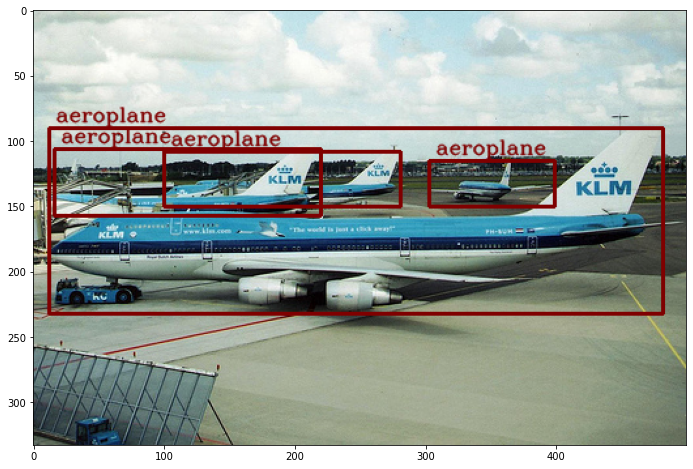

In [15]:
img_file, objects = voc_train[13]
img = Image.open(os.path.join(img_dir, img_file[:4], img_file))

img, objects = preprocess(img, objects, get_difficult=False, normalize_object=False, resize_object=False)
vocv.show_bndbox(img, objects)

In [ ]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, boxes, classes, transform=None):
        if not (len(imgs) == len(boxes) == len(classes)):
            msg = "len(imgs) and len(boxes) and len(classes) must be the same"
            raise ValueError(msg)

        self.imgs = imgs
        self.boxes = boxes
        self.classes = classes
        self.transform = transform

    def __len__(self):
        return len(self.classes)

    def __getitem__(self, idx):
        x = self.imgs[idx]
        box = self.boxes[idx]
        cls = self.classes[idx]

        if self.transform:
            x, box = self.transform(x, box)

        return x, box, cls

In [ ]:
def xyxy_to_cxcywh_float(xmin, ymin, xmax, ymax):
    width = xmax - xmin
    height = ymax - ymin
    xcenter = xmin + width/2
    ycenter = ymin + height/2
    return xcenter, ycenter, width, height

def cxcywh_to_xyxy_float(xcenter, ycenter, width, height):
    xmin = xcenter - width/2
    ymin = ycenter - height/2
    xmax = xmin + width
    ymax = ymin + height
    return xmin, ymin, xmax, ymax

In [ ]:
train_imgs, train_boxes, train_classes = [], [], []
valid_imgs, valid_boxes, valid_classes = [], [], []
valid_file_name = [d[0] for d in voc_valid]

jpg_pattern = re.compile(r"VOCdevkit/VOC2012/JPEGImages/(.*?\.jpg)")
with tarfile.open(tar_path) as tfr:
    for tarinfo in tfr:
        file_name = tarinfo.name
        if "VOCdevkit/VOC2012/JPEGImages" in file_name:
            matches = jpg_pattern.findall(file_name)
            if len(matches) == 0:
                continue
            img, objects = \
                preprocess(
                    Image.open(io.BytesIO(tfr.extractfile(tarinfo).read())),
                    file2obj[matches[-1]], size=(224, 224)
                )
            classes = [o[0] for o in objects]

            if matches[-1] in valid_file_name:
                # boxes = [o[1].flatten() for o in objects]
                boxes = [
                    np.array(xyxy_to_cxcywh_float(*o[1].flatten()))
                    for o in objects
                ]
                valid_imgs.append(np.array(img, dtype=np.float32).transpose(2, 0, 1)/255)
                valid_boxes.append(boxes)
                valid_classes.append(classes)
            else:
                boxes = [
                    np.array(xyxy_to_cxcywh_float(*o[1].flatten()))
                    for o in objects
                ]
                train_imgs.append(np.array(img, dtype=np.float32).transpose(2, 0, 1)/255)
                train_boxes.append(boxes)
                train_classes.append(classes)

"""
for i, (img_file, objects) in enumerate(voc_train):
    if i % 500 == 0:
        print(i, end=", ")
    
    img, objects = preprocess(file2img[img_file], objects, size=(224, 224))
    # to center coords and w, h
    boxes = [
        np.array(xyxy_to_cxcywh_float(*o[1].flatten()))
        for o in objects
    ]
    classes = [o[0] for o in objects]

    train_imgs.append(np.array(img, dtype=np.float32).transpose(2, 0, 1)/255)
    train_boxes.append(boxes)
    train_classes.append(classes)

print()


for i, (img_file, objects) in enumerate(voc_valid):
    if i % 500 == 0:
        print(i, end=", ")
    
    img, objects = preprocess(file2img[img_file], objects, size=(224, 224))
    # to center coords and w, h
    boxes = [
        np.array(xyxy_to_cxcywh_float(*o[1].flatten()))
        for o in objects
    ]
    classes = [o[0] for o in objects]
    
    valid_imgs.append(np.array(img, dtype=np.float32).transpose(2, 0, 1)/255)
    valid_boxes.append(boxes)
    valid_classes.append(classes)"""


print(len(train_imgs), len(train_boxes), len(train_classes))
print(len(valid_imgs), len(valid_boxes), len(valid_classes))

15412 15412 15412
1713 1713 1713


In [ ]:
train = VOCDataset(train_imgs, train_boxes, train_classes)
valid = VOCDataset(valid_imgs, valid_boxes, valid_classes)
len(train), len(valid)
len(valid)

1713

In [ ]:
i = 8
# ch, h, w
print(train[i][0].shape)
# xmin, ymin, xmax, ymax
print(train[i][1])
# class
print(train[i][2])

(3, 224, 224)
[array([0.359     , 0.488     , 0.714     , 0.83733333])]
[18]


In [ ]:
def collate_fn(batch, device=None):
    x = torch.tensor([d[0] for d in batch], dtype=torch.float32, device=device)
    box = [torch.tensor(d[1], dtype=torch.float32, device=device) for d in batch]
    cls = [torch.tensor(d[2], dtype=torch.long, device=device) for d in batch]
    return x, box, cls

In [ ]:
class BackboneNetworks(nn.Module):

    def __init__(self, model_type, output_layers, pretrained=False, dilation=False):
        super(BackboneNetworks, self).__init__()
        self.layers = IntermediateLayerGetter(
            getattr(torchvision.models, model_type)(
                replace_stride_with_dilation=[False, False, dilation],
                pretrained=pretrained,
                norm_layer=FrozenBatchNorm2d
            ),
            output_layers
        )
    
    def forward(self, x):
        return self.layers(x)

In [ ]:
class SinePositionEncoding2D(nn.Module):

    def __init__(self, position_num, half_unit_num):
        super(SinePositionEncoding2D, self).__init__()
        self.position_encoding = self._init_position_encoding(position_num, half_unit_num)

    def _init_position_encoding(self, position_num, half_unit_num):
        pos_arange = torch.arange(1, position_num+1, dtype=torch.float32)
        div_term = 10000 ** (torch.arange(0, half_unit_num, 2, dtype=torch.float32)/half_unit_num)

        pos_x = pos_arange.unsqueeze(dim=0).repeat(position_num, 1)
        pos_y = pos_arange.unsqueeze(dim=1).repeat(1, position_num)

        pos_x = pos_x.unsqueeze(dim=-1) / div_term
        pos_y = pos_y.unsqueeze(dim=-1) / div_term

        pos_x = torch.stack([pos_x.sin(), pos_x.cos()], dim=3).flatten(start_dim=2)
        pos_y = torch.stack([pos_y.sin(), pos_y.cos()], dim=3).flatten(start_dim=2)

        pos = torch.cat([pos_y, pos_x], dim=2).permute(2, 0, 1).unsqueeze(dim=0)
        return pos

    def forward(self, x, device=None):
        x += self.position_encoding.to(device=device)
        return x

    def get_enc(self, device=None):
        return self.position_encoding.to(device=device)

In [ ]:
class PositionwiseFeedForward(nn.Module):

    def __init__(self, hidden_dim, dropout_rate):
        super(PositionwiseFeedForward, self).__init__()
        self.linear_in = nn.Linear(hidden_dim, hidden_dim*4)
        self.linear_out = nn.Linear(hidden_dim*4, hidden_dim)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):  
        x = self.linear_out(self.dropout(F.relu(self.linear_in(x))))
        return x

In [ ]:
class EncoderLayer(nn.Module):

    def __init__(self, hidden_dim, parallel_num, dropout_rate, attention=None):
        super(EncoderLayer, self).__init__()
        if attention:
            self.self_attention = attention
        else:
            self.self_attention = nn.MultiheadAttention(
                    hidden_dim, parallel_num, dropout=dropout_rate
            )
        self.positionwise_feed_forward = \
            PositionwiseFeedForward(hidden_dim, dropout_rate)

        self.dropout_self_attention = nn.Dropout(p=dropout_rate)
        self.dropout_feed_forward = nn.Dropout(p=dropout_rate)
        self.layernorm_self_attention = nn.LayerNorm(hidden_dim)
        self.layernorm_feed_forward = nn.LayerNorm(hidden_dim)

    def forward(self, x_src, pos_enc, src_padding_mask=None):
        
        hidden_src = self.layernorm_self_attention(x_src)
        q = k = hidden_src + pos_enc
        hidden_src, attn_weights = self.self_attention(
            q, k, hidden_src, key_padding_mask=src_padding_mask
        )
        x_src = x_src + self.dropout_self_attention(hidden_src)

        hidden_src = self.layernorm_feed_forward(x_src)
        hidden_src = self.positionwise_feed_forward(hidden_src)
        x_src = x_src + self.dropout_feed_forward(hidden_src)

        return x_src, attn_weights.cpu().detach()

In [ ]:
class Encoder(nn.Module):

    def __init__(self, layer_num, hidden_dim, parallel_num, dropout_rate,
                 share_parameters=False, attention=None):
        super(Encoder, self).__init__()
        if share_parameters:
            layer = EncoderLayer(hidden_dim, parallel_num, dropout_rate, attention=attention)
            layers = [layer for i in range(layer_num)]
        else:
            layers = [
                EncoderLayer(hidden_dim, parallel_num, dropout_rate, attention=attention)
                for i in range(layer_num)
            ]
        self.layers = nn.ModuleList(layers)

    def forward(self, x_src, pos_enc, src_padding_mask=None):

        weights = []
        for i, layer in enumerate(self.layers):
            x_src, attn_weights = layer(
                x_src, pos_enc=pos_enc, src_padding_mask=src_padding_mask
            )
            weights.append(attn_weights)
        
        return x_src, weights

In [ ]:
class DecoderLayer(nn.Module):

    def __init__(self, hidden_dim, parallel_num, dropout_rate, attention=None):
        super(DecoderLayer, self).__init__()
        if attention:
            # More precise implementation is needed.
            self.self_attention = attention
            self.src_tgt_attention = attention
        else:
            self.self_attention = nn.MultiheadAttention(
                    hidden_dim, parallel_num, dropout=dropout_rate
            )
            self.src_tgt_attention = nn.MultiheadAttention(
                    hidden_dim, parallel_num, dropout=dropout_rate
            )
        self.positionwise_feed_forward = \
            PositionwiseFeedForward(hidden_dim, dropout_rate)

        self.dropout_self_attention = nn.Dropout(p=dropout_rate)
        self.dropout_src_tgt_attention = nn.Dropout(p=dropout_rate)
        self.dropout_feed_forward = nn.Dropout(p=dropout_rate)
        self.layernorm_self_attention = nn.LayerNorm(hidden_dim)
        self.layernorm_tgt_attention = nn.LayerNorm(hidden_dim)
        self.layernorm_feed_forward = nn.LayerNorm(hidden_dim)

    def forward(
        self, x_src, x_tgt, pos_enc, query_pos_enc, 
        src_padding_mask=None,
        tgt_padding_mask=None,
        tgt_future_mask=None, 
        ):
        
        hidden_tgt = self.layernorm_self_attention(x_tgt)
        q = hidden_tgt + query_pos_enc
        k = hidden_tgt + query_pos_enc
        hidden_tgt, self_attn_w = self.self_attention(
            q, k, hidden_tgt,
            key_padding_mask=tgt_padding_mask,
            attn_mask=tgt_future_mask
        )
        x_tgt = x_tgt + self.dropout_self_attention(hidden_tgt)

        hidden_tgt = self.layernorm_tgt_attention(x_tgt)
        hidden_tgt += query_pos_enc
        hidden_tgt, st_attn_w = self.src_tgt_attention(
            hidden_tgt,
            x_src+pos_enc,
            x_src,
            key_padding_mask=src_padding_mask
        )
        x_tgt = x_tgt + self.dropout_src_tgt_attention(hidden_tgt)

        hidden_tgt = self.layernorm_feed_forward(x_tgt)
        hidden_tgt = self.positionwise_feed_forward(hidden_tgt)
        x_tgt = x_tgt + self.dropout_feed_forward(hidden_tgt)
        
        attn_weights = (self_attn_w.cpu().detach(), st_attn_w.cpu().detach())

        return x_tgt, attn_weights

In [ ]:
class Decoder(nn.Module):

    def __init__(self, layer_num, hidden_dim, parallel_num, dropout_rate, attention=None):
        super(Decoder, self).__init__()
        layers = [
            DecoderLayer(hidden_dim, parallel_num, dropout_rate, attention=attention)
            for i in range(layer_num)
        ]
        self.layers = nn.ModuleList(layers)

    def forward(
        self, x_src, x_tgt, pos_enc, query_pos_enc,
        src_padding_mask=None,
        tgt_padding_mask=None, 
        tgt_future_mask=None, 
        ):

        x_tgts = []
        weights = []
        for layer in self.layers:
            x_tgt, attn_weights = layer(
                x_src, x_tgt, pos_enc, query_pos_enc,
                src_padding_mask=src_padding_mask,
                tgt_padding_mask=tgt_padding_mask,
                tgt_future_mask=tgt_future_mask,
            )
            x_tgts.append(x_tgt)
            weights.append(attn_weights)
        return x_tgts, weights


In [ ]:
class PredictionHeads(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PredictionHeads, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, h):
        h = F.relu(self.linear1(h))
        h = F.relu(self.linear2(h))
        h = self.linear3(h)
        return h

In [ ]:
def cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [
        (x_c - 0.5 * w), (y_c - 0.5 * h),
        (x_c + 0.5 * w), (y_c + 0.5 * h)
    ]
    return torch.stack(b, dim=-1)

def xyxy_to_cxcywh(x):
    x0, y0, x1, y1 = x.unbind(-1)
    b = [
        (x0 + x1) / 2, (y0 + y1) /2,
        (x1 - x0), (y1 - y0)
    ]
    return torch.stack(b, dim=-1)

def box_iou(boxes1, boxes2):
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)
    
    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    
    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]
    union = area1[:, None] + area2 - inter
    
    iou = inter / union
    return iou, union

def generalized_box_iou(boxes1, boxes2):
    iou, union = box_iou(boxes1, boxes2)
    
    lt = torch.min(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])
    wh = (rb - lt).clamp(min=0)
    area = wh[:, :, 0] * wh[:, :, 1]
    
    giou = iou - (area - union) / area
    return giou

In [ ]:
class HungarianMatcher(nn.Module):
    def __init__(self, weight_cls=1., weight_box=1., weight_giou=1.):
        super(HungarianMatcher, self).__init__()
        self.weight_cls = weight_cls
        self.weight_box = weight_box
        self.weight_giou = weight_giou
    
    @torch.no_grad()
    def forward(self, pred_cls, pred_box, true_cls, true_box):
        bsz, query_num = pred_box.shape[:2]
        box_nums = [len(b) for b in true_box]
        #box_loss_normalizer = sum(box_nums)

        pred_cls = pred_cls.flatten(0, 1).softmax(-1)
        pred_box = pred_box.flatten(0, 1)
        true_cls = torch.cat(true_cls)
        true_box = torch.cat(true_box)
        
        cost_cls = -pred_cls[:, true_cls]
        cost_box = torch.cdist(pred_box, true_box, p=1)# / box_loss_normalizer
        cost_giou = -generalized_box_iou(
            cxcywh_to_xyxy(pred_box),
            cxcywh_to_xyxy(true_box)
        )# / box_loss_normalizer
        
        cost = (
            self.weight_cls * cost_cls +
            self.weight_box * cost_box + 
            self.weight_giou * cost_giou
        )
        cost = cost.view(bsz, query_num, -1).cpu()

        indeces = [
            linear_sum_assignment(c[i])
            for i, c in enumerate(cost.split(box_nums, dim=-1))
        ]
        indeces = [
            (torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64))
            for i, j in indeces
        ]
        
        # list of (tensor(object_query_ids), tensor(id_in_true_label))
        return indeces

In [ ]:
class DETRConfig(object):

    def __init__(self,
                      backbone_type="resnet18",
                      backbone_pretrained=True,
                      backbone_channel=512,
                      backbone_mapsize=7,
                      backbone_dilation=False,
                      trm_layer_num=6,
                      trm_hidden_dim=256,
                      trm_parallel_num=8,
                      trm_dropout=0.1,
                      trm_max_query_num=100,
                      class_num=20,
                      weight_cls=1.,
                      weight_box=5.,
                      weight_giou=2.,
                      add_aux_loss=True,
                      no_obj_weight=0.1,
                      class_loss_weight=None):
        self.backbone_type = backbone_type
        self.backbone_pretrained = backbone_pretrained
        self.backbone_channel = backbone_channel
        self.backbone_mapsize = backbone_mapsize
        self.backbone_dilation = backbone_dilation
        self.trm_layer_num = trm_layer_num
        self.trm_hidden_dim = trm_hidden_dim
        self.trm_parallel_num = trm_parallel_num
        self.trm_dropout = trm_dropout
        self.trm_max_query_num = trm_max_query_num
        self.class_num = class_num
        self.weight_cls = weight_cls
        self.weight_box = weight_box
        self.weight_giou = weight_giou
        self.add_aux_loss = add_aux_loss
        
        if class_loss_weight is None:
            class_loss_weight = torch.ones(class_num+1, dtype=torch.float32)
            class_loss_weight[-1] = no_obj_weight
            self.class_loss_weight = class_loss_weight
        else:
            self.class_loss_weight = class_loss_weight

In [ ]:
"""
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.)
    if type(m) == nn.Embedding:
        nn.init.xavier_normal_(m.weight)
"""

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        #m.bias.data.fill_(0.)
    if type(m) == nn.Embedding:
        nn.init.xavier_uniform_(m.weight)

In [ ]:
class DETR(nn.Module):

    def __init__(self, config):
        super(DETR, self).__init__()

        self.conv_1x1 = nn.Conv2d(config.backbone_channel, config.trm_hidden_dim, kernel_size=1)
        self.pos_enc = SinePositionEncoding2D(config.backbone_mapsize, config.trm_hidden_dim//2)
        self.encoder = Encoder(
            config.trm_layer_num, config.trm_hidden_dim, config.trm_parallel_num, config.trm_dropout
        )
        self.layernorm_encoder = nn.LayerNorm(config.trm_hidden_dim)

        self.object_query = nn.Embedding(config.trm_max_query_num, config.trm_hidden_dim)
        self.decoder = Decoder(
            config.trm_layer_num, config.trm_hidden_dim, config.trm_parallel_num, config.trm_dropout
        )
        self.layernorm_decoder = nn.LayerNorm(config.trm_hidden_dim)

        self.prediction_heads = PredictionHeads(config.trm_hidden_dim, config.trm_hidden_dim, 4)
        self.class_linear = nn.Linear(config.trm_hidden_dim, config.class_num+1)
        
        self.matcher = HungarianMatcher(
            weight_cls=config.weight_cls,
            weight_box=config.weight_box,
            weight_giou=config.weight_giou
        )
        self.class_loss = nn.CrossEntropyLoss(weight=config.class_loss_weight)
        self.box_l1_loss = nn.L1Loss(reduction='none')
        self.weight_cls = config.weight_cls
        self.weight_box = config.weight_box
        self.weight_giou = config.weight_giou
        
        self.trm_max_query_num = config.trm_max_query_num
        self.add_aux_loss = config.add_aux_loss

        self.apply(init_weights)

        self.backbone = BackboneNetworks(
            config.backbone_type, {"layer4": "no_flatten"},
            pretrained=config.backbone_pretrained,
            dilation=config.backbone_dilation
        )
    
    def forward(self, x, device=None):
        h = self.backbone(x)['no_flatten']
        h = self.conv_1x1(h)

        B, C, H, W = h.shape
        h = h.reshape(B, C, H*W).permute(2, 0, 1)
        pos_enc = self.pos_enc.get_enc(device=device).reshape(1, C, H*W).permute(2, 0, 1)

        h, _ = self.encoder(h, pos_enc, src_padding_mask=None)
        h = self.layernorm_encoder(h)

        object_q = self.object_query(
            torch.arange(self.trm_max_query_num, device=device).unsqueeze(dim=0).repeat(B, 1)
        ).permute(1, 0, 2)

        x_tgt = torch.zeros_like(object_q, device=device)
        hs, _ = self.decoder(h, x_tgt, pos_enc, object_q)

        return hs

    def _compute_loss(self, pred_cls, pred_box, true_cls, true_box, print_state=False, device=None):
        indeces = self.matcher(pred_cls, pred_box, true_cls, true_box)
        obj_query_ids = [i[0] for i in indeces]
        id_in_true_label = [i[1] for i in indeces]
        
        box_loss_normalizer = sum([len(c) for c in true_cls])
        bsz, q_num, c_num = pred_cls.shape
        
        true_cls = torch.cat([c[i] for i, c in zip(id_in_true_label, true_cls)])
        # true_cls = [c[i] for i, c in zip(id_in_true_label, true_cls)]
        batch_idx = torch.cat([torch.full_like(q, i) for i, q in enumerate(obj_query_ids)])
        object_idx = torch.cat(obj_query_ids)
        
        true_cls_padded = torch.full((bsz, q_num), c_num-1, dtype=torch.long, device=device)
        true_cls_padded[batch_idx, object_idx] = true_cls
        true_cls = true_cls_padded.reshape(bsz*q_num, )
        
        pred_cls = pred_cls.reshape(bsz*q_num, -1)

        true_box = torch.cat([b[i] for i, b in zip(id_in_true_label, true_box)])
        pred_box = torch.cat([b[q] for q, b in zip(obj_query_ids, pred_box.unbind(dim=0))], dim=0)
        # pred_box = pred_box[batch_idx, object_idx]
        #if print_state:
        #    print(cxcywh_to_xyxy(true_box))
        #    print(cxcywh_to_xyxy(pred_box))
        #    print("="*50)

        class_loss = self.class_loss(pred_cls, true_cls)
        box_l1_loss = self.box_l1_loss(pred_box, true_box).sum() / box_loss_normalizer
        giou_loss = 1 - torch.diag(generalized_box_iou(
            cxcywh_to_xyxy(pred_box),
            cxcywh_to_xyxy(true_box)
        ))
        giou_loss = giou_loss.sum() / box_loss_normalizer
        
        class_loss = self.weight_cls * class_loss
        box_l1_loss = self.weight_box * box_l1_loss
        giou_loss = self.weight_giou * giou_loss
        if print_state:
            print(class_loss.item(), box_l1_loss.item(), giou_loss.item())

        return class_loss, box_l1_loss, giou_loss

    
    def __call__(self, x, true_box, true_cls, device=None, return_loss=False):
        hs = self.forward(x, device=device)
        hs_section = [h.shape[1] for h in hs]
        stack_num = len(hs_section)

        hs = torch.cat(hs, dim=1)
        hs = self.layernorm_decoder(hs)
        boxes = self.prediction_heads(hs).sigmoid().permute(1, 0, 2).split(hs_section, dim=0)
        clses = self.class_linear(hs).permute(1, 0, 2).split(hs_section, dim=0)
        
        box = boxes[-1]
        cls = clses[-1]
        class_loss, box_l1_loss, giou_loss = \
            self._compute_loss(cls, box, true_cls, true_box, print_state=False, device=device)
        
        main_loss = class_loss + box_l1_loss + giou_loss
        if return_loss:
            return {
                "loss": main_loss.item(),
                "class_loss": class_loss.item(),
                "box_l1_loss": box_l1_loss.item(),
                "giou_loss": giou_loss.item(),
            }
        
        if hasattr(self, 'reporter'):
            self.reporter.report({
                "loss": main_loss.item(),
                "class_loss": class_loss.item(),
                "box_l1_loss": box_l1_loss.item(),
                "giou_loss": giou_loss.item(),
            })
        
        if self.add_aux_loss:
            for cls, box in zip(clses[:-1], boxes[:-1]):
                class_loss_aux, box_l1_loss_aux, giou_loss_aux = \
                  self._compute_loss(cls, box, true_cls, true_box, device=device)
                aux_loss = class_loss_aux + box_l1_loss_aux + giou_loss_aux
                main_loss += aux_loss

        return main_loss

    def predict_with_thresh(self, x, threshold=0.5, using_layer=-1, device=None):
        h = self.forward(x, device=device)[using_layer]
        h = self.layernorm_decoder(h)

        box = self.prediction_heads(h).sigmoid().permute(1, 0, 2)
        cls = self.class_linear(h).permute(1, 0, 2).softmax(dim=-1)
        score, cls = cls[:, :, :-1].max(dim=-1)
        
        box = box.unbind(dim=0)
        cls = cls.unbind(dim=0)
        score = score.unbind(dim=0)

        box_remain = [cxcywh_to_xyxy(b[s>=threshold]) for b, s in zip(box, score)]
        cls_remain = [c[s>=threshold] for c, s in zip(cls, score)]

        return cls_remain, box_remain

    def predict(self, x, using_layer=-1, device=None):
        h = self.forward(x, device=device)[using_layer]
        h = self.layernorm_decoder(h)

        box = self.prediction_heads(h).sigmoid().permute(1, 0, 2)
        cls = self.class_linear(h).permute(1, 0, 2)
        no_obj_id = cls.shape[-1]-1

        box = box.unbind(dim=0)
        cls = cls.argmax(dim=-1).unbind(dim=0)

        cls_remain = [c[c != no_obj_id] for c in cls]
        box_remain = [cxcywh_to_xyxy(b[c != no_obj_id]) for c, b in zip(cls, box)]
        return cls_remain, box_remain

In [ ]:
#config = DETRConfig(
#    backbone_type="resnet50", backbone_channel=2048, backbone_mapsize=14, backbone_dilation=True,
#    weight_cls=1., weight_box=2.5, weight_giou=1.,
#    trm_hidden_dim=64, trm_max_query_num=100, add_aux_loss=True, trm_dropout=0.1, no_obj_weight=0.1
#)
#config = DETRConfig(backbone_type="resnet50", backbone_channel=2048, backbone_mapsize=14, backbone_dilation=True,
#                    weight_cls=1., weight_box=2.5, weight_giou=1.)
#config = DETRConfig(weight_cls=1., weight_box=2.5, weight_giou=1.)
config = DETRConfig(backbone_type="resnet50", backbone_channel=2048, backbone_mapsize=14, backbone_dilation=True)
model = DETR(config)

lr_backbone = 1e-5
param_dicts = [
    {"params": [p for n, p in model.named_parameters() if "backbone" not in n and p.requires_grad]},
    {
        "params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad],
        "lr": lr_backbone,
    },
]
optimizer = torch.optim.AdamW(
    param_dicts, lr=1e-4, weight_decay=1e-4
)
"""
optimizer = torch.optim.AdamW(
    [{"params": model.conv_1x1.parameters(), "lr": 1e-4},
     {"params": model.encoder.parameters(), "lr": 1e-4},
     {"params": model.layernorm_encoder.parameters(), "lr": 1e-4},
     {"params": model.object_query.parameters(), "lr": 1e-4},
     {"params": model.decoder.parameters(), "lr": 1e-4},
     {"params": model.layernorm_decoder.parameters(), "lr": 1e-4},
     {"params": model.prediction_heads.parameters(), "lr": 1e-4},
     {"params": model.class_linear.parameters(), "lr": 1e-4},
     {"params": model.backbone.parameters(), "lr": 1e-5}],
    lr=1e-4, weight_decay=1e-4
)
"""

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


'\noptimizer = torch.optim.AdamW(\n    [{"params": model.conv_1x1.parameters(), "lr": 1e-4},\n     {"params": model.encoder.parameters(), "lr": 1e-4},\n     {"params": model.layernorm_encoder.parameters(), "lr": 1e-4},\n     {"params": model.object_query.parameters(), "lr": 1e-4},\n     {"params": model.decoder.parameters(), "lr": 1e-4},\n     {"params": model.layernorm_decoder.parameters(), "lr": 1e-4},\n     {"params": model.prediction_heads.parameters(), "lr": 1e-4},\n     {"params": model.class_linear.parameters(), "lr": 1e-4},\n     {"params": model.backbone.parameters(), "lr": 1e-5}],\n    lr=1e-4, weight_decay=1e-4\n)\n'

In [ ]:
img_ori, box, cls = train[:2]
img = torch.tensor(img_ori, dtype=torch.float32)
box = [torch.tensor(b, dtype=torch.float32) for b in box]
cls = [torch.tensor(c, dtype=torch.long) for c in cls]

NameError: ignored

In [ ]:
model.train()
for i in range(1000):
    optimizer.zero_grad()
    loss = model(img, box, cls)
    loss.backward()
    optimizer.step()
    print(i, "\t", loss.item())

In [ ]:
model.eval()
print(cls)
print(box)
print("="*50)
with torch.no_grad():
    pred_cls, pred_box = model.predict_with_thresh(img, threshold=0.)
    #pred_cls, pred_box = model.predict(img)

img_size = (224, 224)
idx = 1
bs, cs = pred_box[idx], pred_cls[idx]
obj_num = bs.shape[0]
objs = [
    (c, (b.reshape(2, 2)*np.array(img_size)).astype(np.int32)) 
    for c, b in zip(cs.numpy(), tuple(bs.reshape(obj_num, 2, 2).numpy()))
]
img_np = (img_ori[idx]*255).astype(np.uint8).transpose(1, 2, 0)
vocv.show_bndbox(img_np, objs)

In [ ]:
batch_size = 48
epoch_num = 500
report_interval = 100
save_interval = 1

In [ ]:
from functools import partial
collate_fn_gpu = partial(collate_fn, device=torch.device('cuda'))
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, collate_fn=collate_fn_gpu)
valid_loader = torch.utils.data.DataLoader(valid, batch_size, shuffle=False, collate_fn=collate_fn_gpu)
print(len(train), len(valid))
print(len(train_loader), len(valid_loader))

15412 1713
322 36


In [ ]:
reporter = Reporter(print_keys=['main/loss', 'main/class_loss', 'main/box_l1_loss', 'main/giou_loss'])
trainer = Trainer(
    model, optimizer, [train_loader, valid_loader], gpu="gpu",
    reporter=reporter, stop_trigger=(epoch_num, 'epoch'),
    report_trigger=(report_interval, 'iteration'), save_trigger=(save_interval, 'epoch'),
    log_trigger=(save_interval, 'epoch'), eval_trigger=(save_interval, 'epoch'),
    out_dir=model_save_dir, ckpt_path=os.path.join(model_save_dir, 'ckpt_18')
)

restart from 19 epoch.


In [ ]:
print(optimizer.param_groups[0]["lr"], optimizer.param_groups[1]["lr"])
#optimizer.param_groups[0]["lr"] = 1e-5
#optimizer.param_groups[1]["lr"] = 1e-6
#print(optimizer.param_groups[0]["lr"], optimizer.param_groups[1]["lr"])

1e-05 1e-06


In [ ]:
trainer.run()

In [ ]:
def show_bndbox(img_data, objects):
    img = np.array(img_data)
    for c, o in objects:
        mins = o[0]
        font_coord = mins + np.array([5, -5])
        maxs = o[1]
        print(c, mins, maxs)
        cv2.rectangle(img, tuple(mins), tuple(maxs), (255, 0, 0), thickness=2)
        cv2.putText(img, "object", tuple(font_coord), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 0, 0), lineType=cv2.LINE_AA)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.show()

In [ ]:
ckpt = torch.load(os.path.join(model_save_dir, 'model_epoch_18'), map_location=torch.device('cpu'))
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

[(3, array([[ 53, 179],
       [104, 211]], dtype=int32)), (14, array([[ 62, 169],
       [ 85, 200]], dtype=int32))]


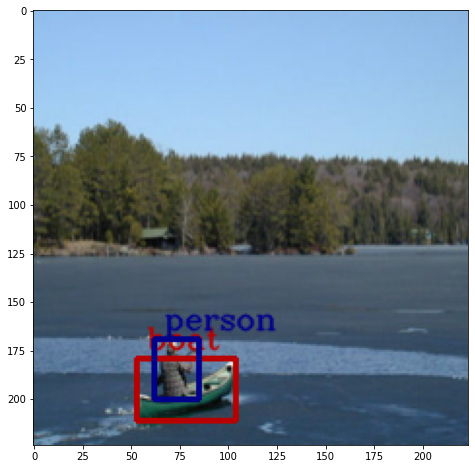

In [ ]:
# idx = 9 inu
# idx = 46 iroiro
# idx = 87 neko
# idx = 95 car
# idx = 124 aeroplane
# idx = 144 train
# idx = 150 boat

# mode="t" idx=20
# mode="t" idx=105
# mode="t" idx=115
# mode="v" idx=0
# mode="v" idx=13
# mode="v" idx=43
# mode="v" idx=393
# mode="v" idx=532
# mode="v" idx=572
# mode="v" idx=612

mode = "v"

idx = 403
if mode == "t":
  img, box, cls = train[idx]
  box = cxcywh_to_xyxy(torch.tensor(box))
  box = [b.numpy() for b in box.unbind(dim=0)]
else:
  img, box, cls = valid[idx]
  box = cxcywh_to_xyxy(torch.tensor(box))
  box = [b.numpy() for b in box.unbind(dim=0)]
img_size = (224, 224)

obj_num = len(box)
objs = [
    (c, (b.reshape(2, 2)*np.array(img_size)).astype(np.int32))
    for c, b in zip(cls, box)
]
img = (img*255).astype(np.uint8).transpose(1, 2, 0)
vocv.show_bndbox(img, objs)

<class 'numpy.ndarray'> float32
[(3, array([[ 62, 176],
       [ 88, 207]], dtype=int32)), (14, array([[ 62, 176],
       [ 88, 207]], dtype=int32)), (3, array([[ 61, 176],
       [ 88, 207]], dtype=int32)), (3, array([[ 62, 176],
       [ 88, 207]], dtype=int32)), (3, array([[ 62, 176],
       [ 88, 207]], dtype=int32)), (3, array([[ 62, 176],
       [ 88, 207]], dtype=int32)), (3, array([[ 62, 176],
       [ 88, 207]], dtype=int32)), (14, array([[ 62, 176],
       [ 88, 207]], dtype=int32)), (14, array([[ 62, 176],
       [ 88, 207]], dtype=int32)), (14, array([[ 62, 176],
       [ 88, 207]], dtype=int32)), (3, array([[ 62, 176],
       [ 88, 207]], dtype=int32)), (14, array([[ 62, 176],
       [ 88, 207]], dtype=int32)), (3, array([[ 62, 176],
       [ 88, 207]], dtype=int32)), (14, array([[ 62, 176],
       [ 88, 207]], dtype=int32)), (3, array([[ 62, 176],
       [ 88, 207]], dtype=int32)), (3, array([[ 62, 176],
       [ 88, 207]], dtype=int32)), (3, array([[ 62, 176],
       [ 8

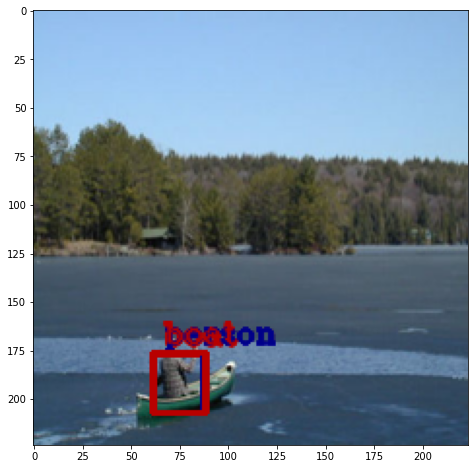

In [ ]:
if mode == "t":
  img, box, cls = train[idx]
else:
  img, box, cls = valid[idx]

print(type(img), img.dtype)

torch.tensor(img, dtype=torch.float32).unsqueeze(dim=0)
model.eval()
with torch.no_grad():
    #cls, box = model.predict(torch.tensor(img, dtype=torch.float32).unsqueeze(dim=0), threshold=0.395) for inu
    cls, box = model.predict_with_thresh(torch.tensor(img, dtype=torch.float32).unsqueeze(dim=0), threshold=0., using_layer=-1)
    #cls, box = model.predict(torch.tensor(img, dtype=torch.float32).unsqueeze(dim=0))

#print(cls[0].shape)
#print(cls)
#print(box)
if len(cls) != 0: 
    obj_num = box[0].shape[0]
    objs = [
        (c, (b.reshape(2, 2)*np.array(img_size)).astype(np.int32))
        for c, b in zip(cls[0].numpy(), tuple(box[0].reshape(obj_num, 2, 2).numpy()))
    ]
    img = (img*255).astype(np.uint8).transpose(1, 2, 0)
    vocv.show_bndbox(img, objs)